### Importing GT

In [1]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from compas.geometry import oriented_bounding_box_numpy
from pytorch3d.ops import box3d_overlap
import torch


PC_PATH = '../labelCloud/pointclouds/cropped_scene1.ply'
GT_JSON = "../labelCloud/labels/cropped_scene1.json"
PRED_JSON = "cropped_predictions_scene1.json"

In [2]:
def compute_3d_IoU(box1, box2):
    box1 = torch.tensor(box1, dtype=torch.float32).unsqueeze(0)
    box2 = torch.tensor(box2, dtype=torch.float32).unsqueeze(0)
    vol, IoU =  box3d_overlap(box1, box2)

    return IoU.item()

In [3]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [4]:
gt = json.load(open(GT_JSON))
for obj in gt['objects']:
    obj['bbox'] = create_obb_from_description(obj['centroid'], obj['dimensions'], obj['rotations']).tolist()

In [5]:
predictions = json.load(open(PRED_JSON))
predicted_objects = predictions['objects']

for obj in predicted_objects:
    obj['bbox'] = np.array(obj['OBB']).reshape(8, 3)
    obj['points'] = np.array(obj['points']).reshape(-1, 3)
    obj['minimum_bbox'] = oriented_bounding_box_numpy(obj['points'])

## Visualize PC and BBoxes

In [6]:
import open3d as o3d
# Load the point cloud from a .ply file
pcd = o3d.io.read_point_cloud(PC_PATH)

In [7]:
def reorder_vertices(box):
    """
    A unit cube, defined with the pythorch3d convention, has the following vertices:
        [0, 0, 0],                    (4) +---------+. (5)
        [1, 0, 0],                        | ` .     |  ` .
        [1, 1, 0],                        | (0) +---+-----+ (1)
        [0, 1, 0],                        |     |   |     |
        [0, 0, 1],                    (7) +-----+---+. (6)|
        [1, 0, 1],                        ` .   |     ` . |
        [1, 1, 1],                        (3) ` +---------+ (2)
        [0, 1, 1],
    
    While the OrientedBoundingBox from Open3D has the following vertices:
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]

    This function reorders the vertices of the OrientedBoundingBox to match the pytorch3d convention.
    This allows to use the official IoU function from Pytorch3D.
    """
    assert box.shape == (8, 3)

    reordered = [
        box[0], box[1], box[7], box[2],
        box[3], box[6], box[4], box[5]
    ]
    return np.array(reordered)

In [8]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = reorder_vertices(np.asarray(bbox.get_box_points()))

class Gt_Obj(Obj):
    def __init__(self, label, bbox):
        super().__init__(label, bbox)
        self.points = None
        self.centroid = np.mean(bbox.get_box_points(), axis=0)
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [0, 1, 0]
        return box

class Pred_Obj(Obj):
    def __init__(self, id, label, bbox, points):
        super().__init__(label, bbox)
        self.points = points
        self.centroid = np.mean(points, axis=0)
        self.id = id
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [1, 0, 0]
        return box


class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [9]:
# Load GT bboxes
gt_boxes = []
for obj in gt["objects"]:
    v = o3d.utility.Vector3dVector(obj["bbox"])
    bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
    gt_boxes.append(Gt_Obj(obj["name"], bbox))

# Load predicted bboxes
pred_boxes = []
for obj in predicted_objects:
    bbox = np.array(obj["minimum_bbox"]).reshape(8, 3)
    v = o3d.utility.Vector3dVector(bbox)
    if np.sum(bbox) == 0:
        continue
    try:
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
        pred_boxes.append(Pred_Obj(obj['id'], obj["label"], bbox, obj["points"]))
    except:
        pass

gt_objects = ObjList(gt_boxes)
pred_objects = ObjList(pred_boxes)

In [10]:
idx = 0
label2idx = {}
for obj in gt_objects:
    if obj.label not in label2idx:
        label2idx[obj.label] = idx
        idx += 1

for obj in pred_objects:
    if obj.label not in label2idx:
        label2idx[obj.label] = idx
        idx += 1

id2label = {v: k for k, v in label2idx.items()}
label2idx, id2label

({'tv': 0,
  'backpack': 1,
  'handbag': 2,
  'chair': 3,
  'laptop': 4,
  'bottle': 5,
  'person': 6,
  'dining table': 7},
 {0: 'tv',
  1: 'backpack',
  2: 'handbag',
  3: 'chair',
  4: 'laptop',
  5: 'bottle',
  6: 'person',
  7: 'dining table'})

In [11]:
def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        vis.add_geometry(obj.OBB())

    for obj in pred_objects:
        vis.add_geometry(obj.OBB())

    vis.run()
    vis.destroy_window()

In [12]:
custom_draw_geometry(pcd, gt_objects, pred_objects)

In [13]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_3d_IoU(gt_box, pred_box)
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    gt_boxes = gt_objects.get_boxes_list()
    pred_boxes = pred_objects.get_boxes_list()
    iou_matrix = compute_3d_iou_matrix(gt_boxes, pred_boxes)

    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [
        pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds
    ]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    ious = [match["iou"] for match in matched_couples]
    assert len(ious) == len(set(ious))
    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt


matching, phantom_preds, missed_gt = get_matches(gt_objects, pred_objects, 0.0)

In [14]:
for match in matching:
    print(f"GT: {match['gt'].label}, Pred: {match['pred'].label}, IoU: {match['iou']}")

GT: backpack, Pred: backpack, IoU: 0.5514132380485535
GT: tv, Pred: tv, IoU: 0.49898862838745117
GT: tv, Pred: tv, IoU: 0.4683142304420471
GT: person, Pred: person, IoU: 0.4601234793663025
GT: chair, Pred: chair, IoU: 0.35232895612716675
GT: handbag, Pred: handbag, IoU: 0.3236021101474762
GT: laptop, Pred: laptop, IoU: 0.21490372717380524
GT: laptop, Pred: laptop, IoU: 0.15441861748695374
GT: dining table, Pred: bottle, IoU: 0.026758858934044838


In [15]:
custom_draw_geometry(pcd, ObjList(phantom_preds), ObjList(missed_gt))

In [16]:
def compute_confusion_matrix(matches, phantom_preds, missed_gt, label2idx, iou_threshold=0.5):
    num_classes = len(label2idx)
    conf_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    y_true = []
    y_pred = []
    
    for match in matches:
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        iou = match['iou']

        if iou >= iou_threshold:
            conf_matrix[gt_idx, pred_idx] += 1
        else:
            conf_matrix[gt_idx, num_classes] += 1  # FN
            conf_matrix[num_classes, pred_idx] += 1  # FP
    
    for missed in missed_gt:
        gt_idx = label2idx[missed.label]
        conf_matrix[gt_idx, num_classes] += 1
    
    for phantom in phantom_preds:
        pred_idx = label2idx[phantom.label]
        conf_matrix[num_classes, pred_idx] += 1

    return conf_matrix

conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, iou_threshold=0.0)
conf_matrix

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [23]:
len(phantom_preds), len(missed_gt)

(0, 2)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics_from_confusion_matrix(conf_matrix, num_classes):
    y_true = []
    y_pred = []
    
    for i in range(num_classes + 1):
        for j in range(num_classes + 1):
            y_true.extend([i] * conf_matrix[i, j])
            y_pred.extend([j] * conf_matrix[i, j])
    
    precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes + 1))
    recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes + 1))
    f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes + 1))
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    return precision[:-1], recall[:-1], f1[:-1], accuracy

precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))

/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

(array([0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0. ]),
 <Axes: xlabel='Recall', ylabel='Precision'>)

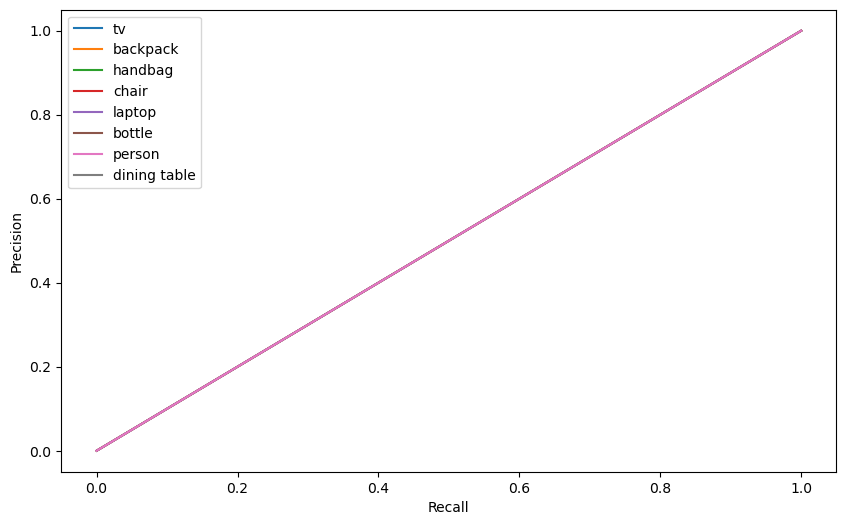

In [68]:
def AP(matching, phantom_preds, missed_gt, label2idx, return_ax_plot=False):
    precisions, recalls, f1s, accuracies = [], [], [], []

    for thr in np.linspace(0, 1, 100):
        conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, iou_threshold=thr)
        precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(accuracy)
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    accuracies = np.array(accuracies)

    num_thresholds, num_classes = precisions.shape
    ap = np.zeros(num_classes)

    for i in range(num_classes):
        # Ensure recall is sorted in ascending order
        recall_sorted_indices = np.argsort(recalls[:, i])
        sorted_recall = recalls[recall_sorted_indices, i]
        sorted_precision = precisions[recall_sorted_indices, i]

        # Calculate AP using the trapezoidal rule
        ap[i] = np.trapz(sorted_precision, sorted_recall)
    
    if return_ax_plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        for i in range(num_classes):
            ax.plot(recalls[:, i], precisions[:, i], label=id2label[i])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()

        return ap, ax

    return ap, None


AP(matching, phantom_preds, missed_gt, label2idx, True)

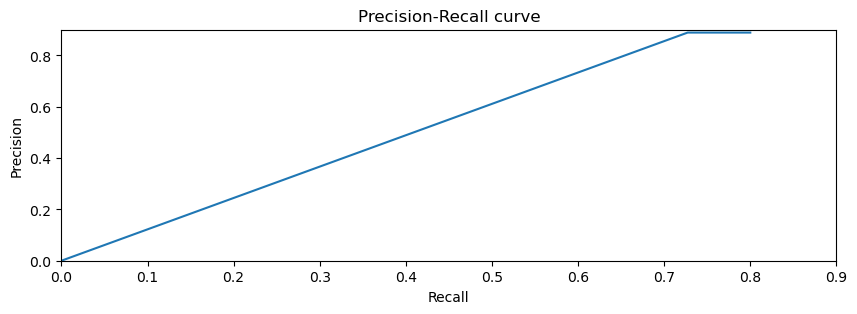

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(recalls, precisions)
ax.set_xlim([0, 0.9])
ax.set_ylim([0, 0.9])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall curve")
plt.show()